In [ ]:
# download img
!gdown --id 1hdzThXI1T2Na4cPbfizxvGIQeiF17JCf

Downloading...
From: https://drive.google.com/uc?id=1hdzThXI1T2Na4cPbfizxvGIQeiF17JCf
To: /content/img_377_ROI.jpg
100% 13.2k/13.2k [00:00<00:00, 21.7MB/s]


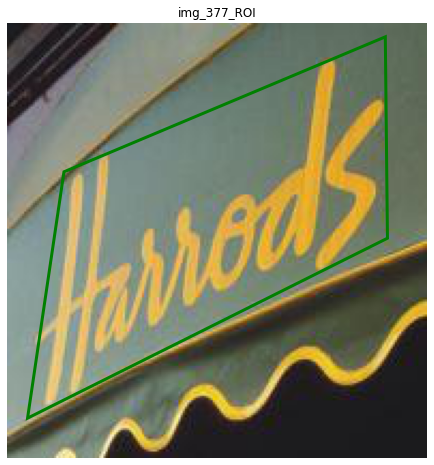

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# mask gt
mask_gt = np.array([[9, 184],
                 [177, 100],
                 [176, 6],
                 [26, 69]])

# bb gt
bb_coords = np.array([[9, 184, 179, 6]])

filename = './img_377_ROI.jpg'
img = plt.imread(filename)

# show img & mask
fig,ax = plt.subplots(1, 1, figsize=(15,8))
ax.imshow(img)
ax.set_title('img_377_ROI')
ax.axis('off')
# ax.add_patch(patches.Rectangle((bb_coords[0][0],bb_coords[0][3]), bb_coords[0][2] - bb_coords[0][0], bb_coords[0][1] - bb_coords[0][3],
#                                linewidth=1, edgecolor='b', facecolor='none'))
ax.add_patch(patches.Polygon(mask_gt, linewidth=3, edgecolor='g', facecolor='none'))
plt.show()

# Softmask

In [ ]:
import math

# ABCD co-ordinates
[[xA, yA], [xB, yB], [xC, yC], [xD, yD]] = mask_gt

# O co-ordinate
O = mask_gt.mean(axis=0, dtype=int).reshape((2,1))

# pixel space
X = np.arange(img.shape[1]).reshape((-1,1))
Y = np.arange(img.shape[0]).reshape((-1,1))
XX, YY = np.meshgrid(X, Y)
XYpairs = np.dstack([XX, YY]).reshape(-1, 2, 1)
XYpairs -= O

# 4 regions (R_OMN)
regions = np.array([[[xA,xB],
                     [yA,yB]],
                    [[xB,xC],
                     [yB,yC]],
                    [[xC,xD],
                     [yC,yD]],
                    [[xD,xA],
                     [yD,yA]]])
regions -= O
regions = np.linalg.inv(regions)

# calculate alpha & beta for each regions of each pixel
alpha_beta_space = np.tensordot(XYpairs, regions, axes=((1),(2))).reshape(-1, regions.shape[0], 2, 1)
alpha_beta_space[np.where( alpha_beta_space < 0 )] = -math.inf
alpha_beta_sum_chosen = np.sum(alpha_beta_space, axis=2).max(axis=1)

# pixel score
pixel_score = 1 - alpha_beta_sum_chosen 
pixel_score = pixel_score.reshape((-1, X.shape[0]))
pixel_score[O[1][0]][O[0][0]] = 1
# add noise
# noise = np.random.uniform(-0.16, -0.07, pixel_score.shape)
noise = np.random.uniform(-0.16, -0.1, pixel_score.shape)
pixel_score += noise
pixel_score[np.where(pixel_score < 0)] = 0
pixel_score[np.where(pixel_score > 1)] = 1
noise = np.random.uniform(-0.001, 0.1005, pixel_score.shape)
pixel_score += noise
pixel_score[np.where(pixel_score < 0)] = 0
pixel_score[np.where(pixel_score > 1)] = 1

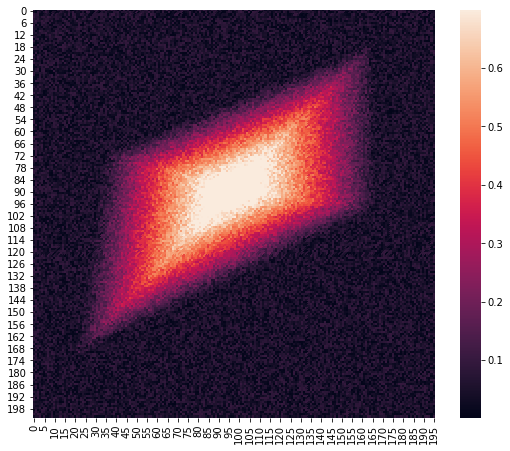

In [ ]:
import seaborn as sns

# heatmap for softmask
fig,ax = plt.subplots(1, 1, figsize=(9, 7.5))
ax = sns.heatmap(pixel_score, robust=True)
plt.show()

# Plane Clustering

In [ ]:
import torch

# plane_init
def plane_init(pos_points, ideal_value):
  center = torch.mean(pos_points, dim=0)
  vector = torch.as_tensor([center[0], center[1], ideal_value]) - torch.as_tensor([
    [center[0], 0, 0], [pixel_score.shape[0], center[1], 0], [center[0], pixel_score.shape[1], 0], [0, center[1], 0]
  ])

  planes = torch.empty((3, 4), dtype=torch.float64)
  planes[:2] = -ideal_value * vector[:, :2].t()
  param_C = vector[:, 0] ** 2 + vector[:, 1] ** 2
  if not torch.all(param_C > 0.1):
    raise ValueError('No enough points for some planes')
  planes[:2] /= param_C
  planes[2] = - (ideal_value + torch.matmul(center[:2], planes[:2]))

  ones = torch.ones((1, 4), dtype=torch.float64)
  ans = torch.abs(torch.matmul(pos_points, torch.cat([planes, ones])))
  partition = torch.argmin(ans, dim=1)
  point_groups = [pos_points[partition == i] for i in range(planes.shape[1])]

  return planes, center

# plane_clustering
def plane_clustering(pos_points, planes, iter_num=10):
  ones = torch.ones((1, 4), dtype=torch.float64)
  RLS_planes = []
  for iter in range(iter_num):
    ans = torch.abs(torch.matmul(pos_points, torch.cat([planes, ones])))
    partition = torch.argmin(ans, dim=1)
    point_groups = [pos_points[partition == i] for i in range(planes.shape[1])]
    for i, group in enumerate(point_groups):
      if len(group) == 0:
        continue
      X = group[:, :3]
      B = -group[:, 3:]
      # A = torch.gels(B, X)[0][:3]
      A = torch.lstsq(B, X)[0][:3]
      abs_residuals = torch.abs(torch.matmul(X, A) - B)
      abs_residual_scale = torch.median(abs_residuals)
      if abs_residual_scale > 1e-4:
        X_weight = abs_residuals / (6.9460 * abs_residual_scale)
        X_weight[X_weight > 1] = 0
        X_weight[X_weight <= 1] = (1 - X_weight[X_weight <= 1] ** 2) ** 2
        X_weighted = X_weight * X
        X = torch.matmul(X_weighted.t(), X)
        B = torch.matmul(X_weighted.t(), B)
        # A = torch.gels(B, X)[0]
        A = torch.lstsq(B, X)[0]
      planes[:, i] = A.flatten()
    RLS_planes.append(planes.clone().detach())
  return planes, RLS_planes

# get_intersection_of_plane
def get_intersection_of_plane(normal_vectors):
  """
  :param normal_vectors: [M = 4, {A, B, D}]
  :return:
  """
  points = torch.empty((4, 2), dtype=torch.float64)
  for i in range(4):
    param = normal_vectors[:, [i, (i + 1) % 4]]
    coefficient = param[:2].t()
    ordinate = -param[2]
    # points[i] = torch.gels(ordinate, coefficient)[0].squeeze()
    points[i] = torch.lstsq(ordinate, coefficient)[0].squeeze()
  return points

In [ ]:
mask = torch.tensor(pixel_score).T # 196 x 203
xx, yy = np.meshgrid(np.arange(mask.shape[1]),np.arange(mask.shape[0]))

# all points without z scores
assist_info = torch.tensor(np.array([xx.flatten(),
                                     yy.flatten(),
                                     np.ones(xx.flatten().shape)]
                                    ).T.reshape(mask.shape[0],
                           mask.shape[1],3)) # 196 x 203

# all points with z scores
src_points = torch.cat([assist_info, mask[..., None]], dim=2) # 196 x 203

# positive points
pos_points = src_points[(mask > 0.1) & (mask < 0.8)]

In [ ]:
# init planes, init groups, O
p_init, center = plane_init(pos_points, 1)

# last planes, RLS_planes
p_cl, RLS_planes = plane_clustering(pos_points, p_init.clone().detach())

# Visualization

In [ ]:
def cal_region_matrix(M, N, O, XX, YY):  
  # M,N co-ordinates
  [xM, yM], [xN, yN] = M, N

  # pixel space
  XYpairs = np.dstack([XX, YY]).reshape(-1, 2, 1)
  XYpairs -= O

  # R_OMN
  regions = np.array([[xM,xN],
                      [yM,yN]])
  regions -= O
  regions = np.linalg.inv(regions)

  # calculate alpha & beta
  alpha_beta_space = np.tensordot(XYpairs, regions, axes=((1),(1))).reshape((-1, 2, 1))
  alpha_beta_space[np.where( alpha_beta_space < 0 )] = -math.inf
  alpha_beta_sum_chosen = np.sum(alpha_beta_space, axis=1).reshape((-1, XX.shape[1]))
  alpha_beta_sum_chosen[alpha_beta_sum_chosen < 0] = np.nan
  alpha_beta_sum_chosen[alpha_beta_sum_chosen > 1] = np.nan
  alpha_beta_sum_chosen[1 - alpha_beta_sum_chosen >= 0] = 1

  return alpha_beta_sum_chosen

def cal_planes_z_and_text_box(planes, xGrid, yGrid):
  # init planes z
  p_z = [[], [], [], []]
  # intersection
  p_inter = get_intersection_of_plane(planes)
  for i in range(4):
    # ith plane z
    ith_p_z = - planes[:,i][0] * xGrid - planes[:,i][1] * yGrid - planes[:,i][2]

    # ith plane selected region
    ith_p_selected_z = cal_region_matrix(np.array(p_inter[i-1]), np.array(p_inter[i]), np.array(center, dtype=int)[:2].reshape((2,1)), xGrid, yGrid)

    p_z[i] = ith_p_z * ith_p_selected_z

  return p_z, np.array(p_inter).T

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

subplot_titles = ['All points',  'Positive points', 'Init planes']

# Initialize figure
fig = make_subplots(
  rows=1, cols=3,
  specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
  subplot_titles=subplot_titles
)

# Generate space
x = np.linspace(0, 202, 203)
y = np.linspace(0, 195, 196)
xGrid, yGrid = np.meshgrid(x, y)

# adding surfaces to subplots.
# (1,1): all points
  # softmask heatmap
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=0*xGrid,
             showscale=False,
             surfacecolor=mask),
  row=1, col=1)
  # all points
fig.add_trace(
  go.Scatter3d(x=src_points.T[0].flatten(),
               y=src_points.T[1].flatten(),
               z=src_points.T[3].flatten(),
               opacity=1,
               mode='markers',
               marker=dict(
               color='rgb(0,255,0)',
               size=1,
               sizemode='diameter')),
  row=1, col=1)

# (1,2): positive points
  # softmask heatmap
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=0*xGrid,
             showscale=False,
             surfacecolor=mask),
  row=1, col=2)
  # positive points
fig.add_trace(
  go.Scatter3d(x=pos_points[:,0],
               y=pos_points[:,1],
               z=pos_points[:,3],
               opacity=1,
               mode='markers',
               marker=dict(
               color='rgb(0,255,255)',
               size=1,
               sizemode='diameter')),
  row=1, col=2)

# (1,3): init planes
p_init_z, init_text_box = cal_planes_z_and_text_box(p_init, xGrid, yGrid)
  # softmask heatmap
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=0*xGrid,
             showscale=False,
             surfacecolor=mask),
  row=1, col=3)
  # plane 1
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=p_init_z[0],
             showscale=False,
             opacity=0.5),
  row=1, col=3)
  # plane 2
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=p_init_z[1],
             showscale=False,
             opacity=0.5),
  row=1, col=3)
  # plane 3
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=p_init_z[2],
             showscale=False,
             opacity=0.5),
  row=1, col=3)
  # plane 4
fig.add_trace(
  go.Surface(x=xGrid,
             y=yGrid,
             z=p_init_z[3],
             showscale=False,
             opacity=0.5),
  row=1, col=3)
  # text box
fig.add_trace(
  go.Scatter3d(x=init_text_box[0],
               y=init_text_box[1],
               z=0*init_text_box[0],
               mode="lines",
               line=dict(
               color='rgb(0,255,0)',
               width=2)),
  row=1, col=3)

# layout
fig.update_layout(
    height=600,
    width=1500,
    hovermode=False,
    showlegend=False
)

fig.show()

## Plane Clustering

In [ ]:
subplot_titles = []
for i in range(5):
  subplot_titles.append(f'RLS iter={i+1}')

# Initialize figure
fig = make_subplots(
  rows=1, cols=5,
  specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
  subplot_titles=subplot_titles
)

# RLS iters (1-5)
for col in range(5):
  p_z, text_box = cal_planes_z_and_text_box(RLS_planes[col], xGrid, yGrid)
  # softmask heatmap
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=0*xGrid,
                showscale=False,
                surfacecolor=mask),
    row=1, col=col+1)
  # plane 1
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[0],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 2
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[1],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 3
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[2],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 4
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[3],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # text box
  fig.add_trace(
    go.Scatter3d(x=text_box[0],
                  y=text_box[1],
                  z=0*text_box[0],
                  mode="lines",
                  line=dict(
                  color='rgb(0,255,0)',
                  width=2)),
    row=1, col=col+1)

# layout
fig.update_layout(
    title_text='Plane Clustering',
    height=580,
    width=1750,
    hovermode=False,
    showlegend=False
)

fig.show()

In [ ]:
subplot_titles = []
for i in range(5):
  subplot_titles.append(f'RLS iter={i+6}')

# Initialize figure
fig = make_subplots(
  rows=1, cols=5,
  specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
  subplot_titles=subplot_titles
)

# RLS iters (1-5)
for col in range(5):
  p_z, text_box = cal_planes_z_and_text_box(RLS_planes[col+5], xGrid, yGrid)
  # softmask heatmap
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=0*xGrid,
                showscale=False,
                surfacecolor=mask),
    row=1, col=col+1)
  # plane 1
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[0],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 2
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[1],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 3
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[2],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # plane 4
  fig.add_trace(
    go.Surface(x=xGrid,
                y=yGrid,
                z=p_z[3],
                showscale=False,
                opacity=0.5),
    row=1, col=col+1)
  # text box
  fig.add_trace(
    go.Scatter3d(x=text_box[0],
                  y=text_box[1],
                  z=0*text_box[0],
                  mode="lines",
                  line=dict(
                  color='rgb(0,255,0)',
                  width=2)),
    row=1, col=col+1)

# layout
fig.update_layout(
    title_text='Plane Clustering',
    height=580,
    width=1750,
    hovermode=False,
    showlegend=False
)

fig.show()